In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import matplotlib as mpl
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

# Pattern Spectra (PS)

![](img/ps.svg)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [2]:
# Your turn!
tile_path  = Path("data/dsm_vox_50cm_tile_-7_1.tif")
dsm = rio.open(tile_path).read(1)
maxtree =sap.MaxTree(dsm)

## 1. Compute attributes and visualize the distrbution of values

- Compute the `area` and `compactness` attributes
- How can we visualize the distribution of values? Display the distribution of areas, then compactness.
    + Tip: you can some matplotlib functions to plot the visualizations!

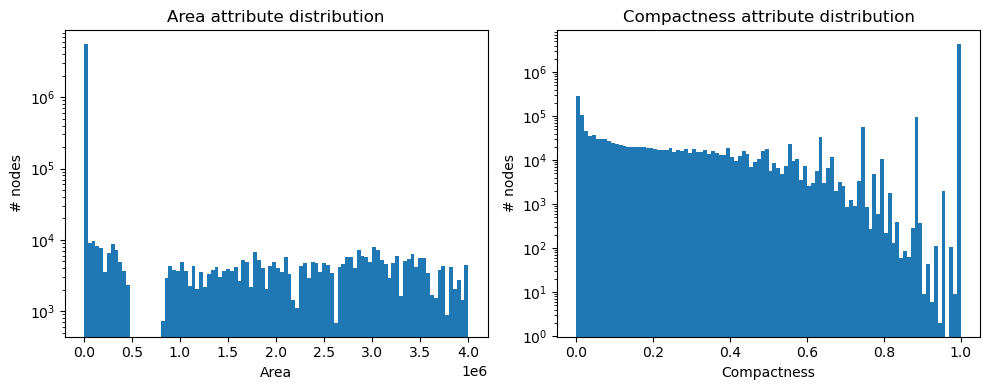

In [57]:
# Your turn!
# area attribute
area = maxtree.get_attribute('area')
compactness = maxtree.get_attribute('compactness')

# histogram to show distribution of attributes
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(area, bins=100)  
plt.title('Area attribute distribution')
plt.xlabel('Area')
plt.ylabel('# nodes')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(compactness, bins=100)  
plt.title('Compactness attribute distribution')
plt.xlabel('Compactness')
plt.ylabel('# nodes')
plt.yscale('log')

plt.tight_layout()
plt.show()

# 2. Compute a Pattern Spectrum

The pattern spectrum can be seen as nodes attributes probability distribution: for a given attribute value we display the probability to have nodes with these properties in the image.

To compute the Pattern Spectrum, you need to weight the histograms with the area of the flat zone times the height diffence of the flat zone and its direct ancester.

- Compute and display the Pattern Spectrum
    - For `area` attributes
    - For `compactness` attributes

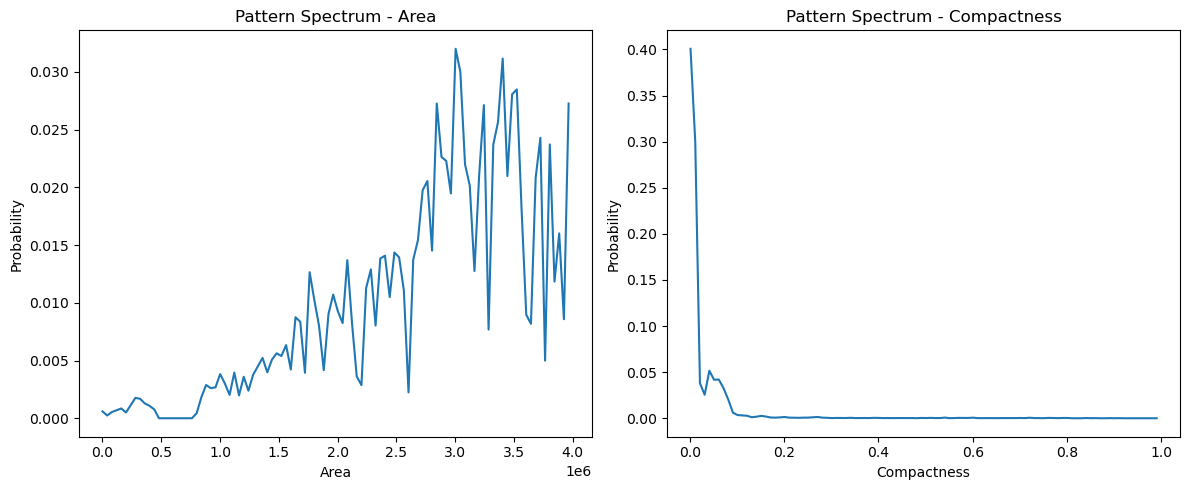

In [39]:
# Your turn!

# attribute pattern spectrum
## Node values
height = maxtree.get_attribute('height')  

# Weight for pattern spectrum
weights = area * height

# pattern spectra - area
hist_area, bin_area = np.histogram(area, weights=weights, bins=100)
prob_area = hist_area / np.sum(hist_area)

# pattern spectra - compactness
hist_compactness, bin_compactness = np.histogram(compactness, weights=weights, bins=100)
prob_compactness = hist_compactness / np.sum(hist_compactness)


# visualize 
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(bin_area[:-1], prob_area)
plt.title("Pattern Spectrum - Area")
plt.xlabel("Area")
plt.ylabel("Probability")

plt.subplot(1,2,2)
plt.plot(bin_compactness[:-1], prob_compactness)
plt.title("Pattern Spectrum - Compactness")
plt.xlabel("Compactness")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()


## 3. Compute and display a 2D Pattern Spectrum with SAP

- Compute a 2D PS with SAP
- Find objet of interrest in the spectrum
- Filter the DSM according to the object of interest in the spectum

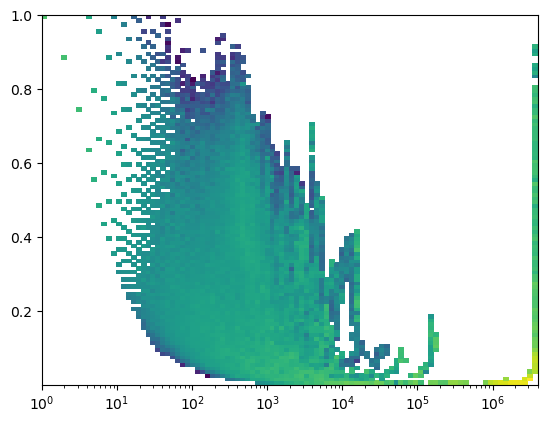

In [40]:
ps_2d = sap.spectrum2d(maxtree, 'area', 'compactness', x_log=True)
sap.show_spectrum(*ps_2d)

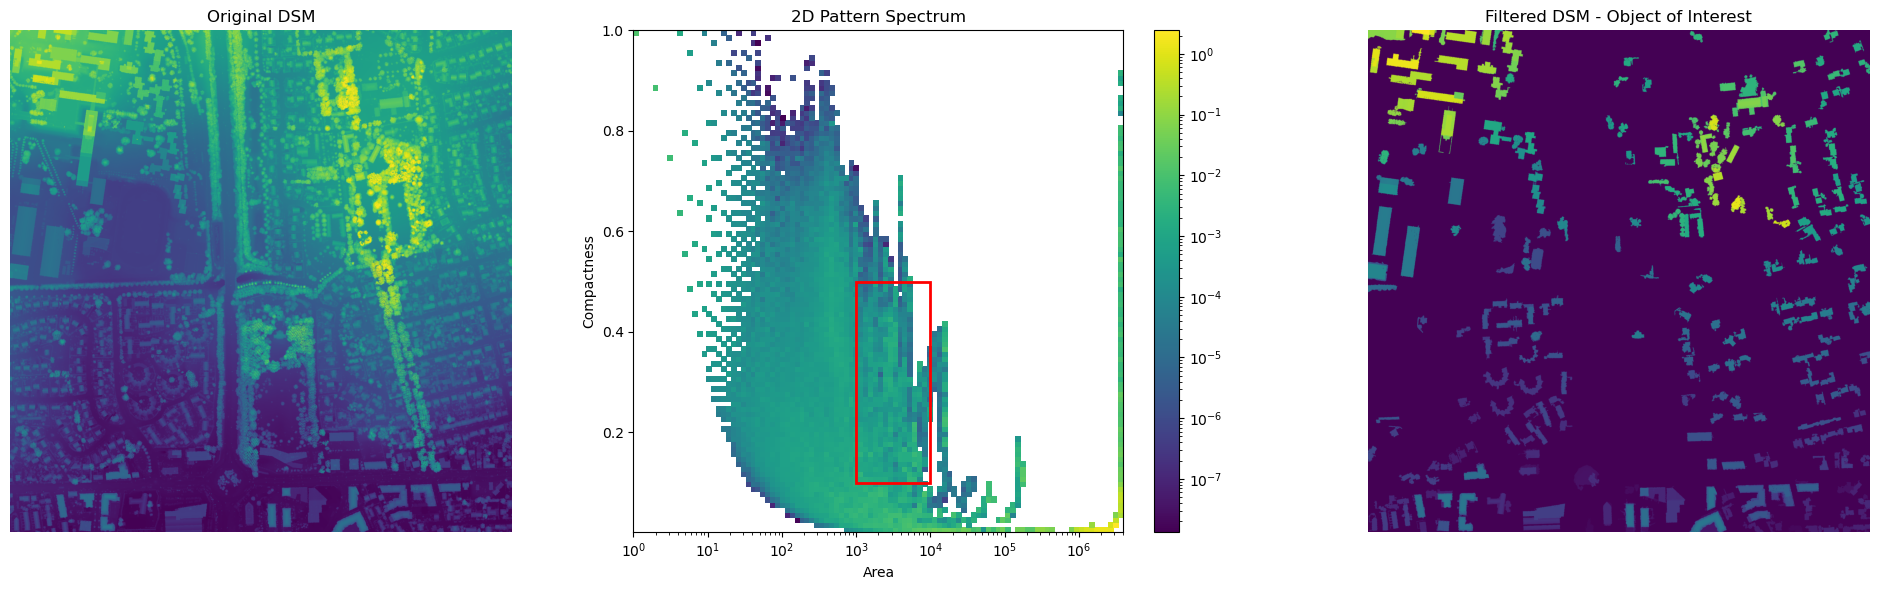

In [ ]:
import matplotlib.patches as patches

s, xedges, yedges, x_log, y_log = ps_2d  # unpack SAP output

# object of interest
area_thresh = (1000, 10000)         
compactness_thresh = (0.1, 0.5) 

# Filter DSM according to thresholds
deleted_nodes = (area >= area_thresh[0]) & (area <= area_thresh[1]) & \
       (compactness >= compactness_thresh[0]) & (compactness <= compactness_thresh[1])
filtered_dsm = maxtree.reconstruct(~deleted_nodes)

# Plot
plt.figure(figsize=(20,6))

#original DSM
plt.subplot(1, 3, 1)
plt.imshow(dsm)
plt.title('Original DSM')
plt.axis('off')

#2D Pattern Spectrum
plt.subplot(1, 3, 2)
sap.show_spectrum(*ps_2d)
plt.xlabel('Area')
plt.ylabel('Compactness')
plt.title('2D Pattern Spectrum')
plt.colorbar()

# Add rectangle for thresholds
rect = patches.Rectangle(
    (area_thresh[0], compactness_thresh[0]),  # lower-left corner
    area_thresh[1]-area_thresh[0],            # width
    compactness_thresh[1]-compactness_thresh[0],  # height
    linewidth=2, edgecolor='red', facecolor='none'
)
plt.gca().add_patch(rect)

#Filtered DSM
plt.subplot(1, 3, 3)
plt.imshow(filtered_dsm)
plt.title('Filtered DSM - Object of Interest')
plt.axis('off')

plt.tight_layout()
plt.show()
